The Implications Of The Cauchy Distribution Of Returns On A Long Position In The Market.

Want to Compare the Cauchy Distribution (the most pathological) to the assumed Normal Distribution of market returns. My hypothesis is that returns have fatter tails than assumed and hedging against a long position will require a larger put position. Whether a SPX put or other instruments are the optimal hedging choice is beyond the scope of this paper. The purpose of this project is not build a better model of returns, rather it is to demonstrate unassumed risk endangers portfolios and must be hedged.

FROM SPX Analysis.ipynb

# Imports

In [1]:
import scipy
from scipy import special
from scipy.stats import cauchy
from scipy.stats import norm
from scipy.stats import rv_continuous
from scipy.stats import powerlaw
from scipy.stats import pareto
import math
import pandas as pd
import pandas_datareader as web
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import random

import math
import pandas_datareader as web

!pip install yfinance

import yfinance as yf
import datetime 

pd.set_option('max_columns', 10)
pd.set_option('max_rows', 15)

from pprint import pprint

     |████████████████████████████████| 6.4 MB 6.3 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


# Comparing Distributions of Returns of S&P 500

In [2]:
url_spx = 'https://www.multpl.com/s-p-500-historical-prices/table/by-month'

In [ ]:
# Create the SPX dataframe

df_spx = pd.read_html(url_spx)
spx = df_spx[0] 

spx = spx.rename(columns= {'Price Value': 'Price'})
spx = spx.rename(columns= {'Date': 'Date'})

spx['Returns'] = spx['Price'].pct_change(-1)
spx = spx.dropna()

spx.set_index('Date', inplace = True) # Change the dataset to be indexed at 'Date'

# Create 'Rank' Column
numbers = range(1, len(spx)+1)
rank = []
for number in numbers:
  rank.append(number)

spx['Rank'] = rank

# Rank Returns
spx_1 = spx.sort_values(by=['Returns'])
spx_1['Ranked Returns'] = spx_1['Returns']
spx_1 = spx_1['Ranked Returns']
spx_1 = spx_1.to_list()
spx['Ranked Returns'] = spx_1

display(spx)

,Price,Returns,Rank,Ranked Returns
Date,,,,
"Feb 11, 2022",4418.64,-0.036742,1,-0.264737
"Feb 1, 2022",4587.18,0.002921,2,-0.239709
"Jan 1, 2022",4573.82,-0.021595,3,-0.203911
"Dec 1, 2021",4674.77,0.001581,4,-0.190681
"Nov 1, 2021",4667.39,0.046333,5,-0.187680
...,...,...,...,...
"Jun 1, 1871",4.82,-0.008230,1810,0.120217
"May 1, 1871",4.86,0.025316,1811,0.171364
"Apr 1, 1871",4.74,0.028200,1812,0.198825


In [ ]:
# Calculate Some Statistics on S&P 500 Returns
median = spx['Returns'].median()
upper_q = spx['Returns'].quantile(q=0.75) # Upper Quartile
lower_q = spx['Returns'].quantile(q=0.25) # Lower Quartile
iqr = (upper_q - lower_q)/2 # Interquartile Range

average = spx['Returns'].mean()
stdev = spx['Returns'].std()
mode = spx['Returns'].mode()

stats = pd.Series({'Average': average, 'Stdev': stdev, 'Upper Q': upper_q, 'Lower Q': lower_q, 'Median': median, 'IQR': iqr})

display(stats)

Average    0.004635
Stdev      0.040597
Upper Q    0.027544
Lower Q   -0.014974
Median     0.006700
IQR        0.021259
dtype: float64

In [ ]:
# Build Distributions

# Empirical CDF
spx['Empirical CDF'] = spx['Rank']/len(spx)

# Normal CDF
spx['Normal CDF'] = norm.cdf(spx['Ranked Returns'], average, stdev)

# Cauchy CDF moments
spx['Cauchy CDF (method of moments)'] = cauchy.cdf(spx['Ranked Returns'], median, iqr)

# Cauchy PDF Maximum Likelihood
spx['Cauchy PDF (ML)'] = cauchy.logpdf(spx['Ranked Returns'], median, iqr)

# Maximize the log_likelihood of Cauchy
median_mle, iqr_mle = cauchy.fit(spx['Ranked Returns'])
print('MLE MU:   ', median_mle)
print('MLE Gamma: ', iqr_mle)
print()

# Cauchy CDF Maximum Likelihood
spx['Cauchy CDF (ML)'] = cauchy.cdf(spx['Ranked Returns'], median_mle, iqr_mle)

display(spx)

MLE MU:    0.007737750668361415
MLE Gamma:  0.01970807063328954



,Price,Returns,Rank,Ranked Returns,Empirical CDF,Normal CDF,Cauchy CDF (method of moments),Cauchy PDF (ML),Cauchy CDF (ML)
Date,,,,,,,,,
"Feb 11, 2022",4418.64,-0.036742,1,-0.264737,0.000551,1.619310e-11,0.024879,-2.393769,0.022983
"Feb 1, 2022",4587.18,0.002921,2,-0.239709,0.001103,8.786189e-10,0.027395,-2.201595,0.025299
"Jan 1, 2022",4573.82,-0.021595,3,-0.203911,0.001654,1.395801e-07,0.032022,-1.890357,0.029555
"Dec 1, 2021",4674.77,0.001581,4,-0.190681,0.002205,7.505239e-07,0.034152,-1.761994,0.031513
"Nov 1, 2021",4667.39,0.046333,5,-0.187680,0.002756,1.083503e-06,0.034675,-1.731716,0.031994
...,...,...,...,...,...,...,...,...,...
"Jun 1, 1871",4.82,-0.008230,1810,0.120217,0.997795,9.977939e-01,0.941071,-0.678567,0.944788
"May 1, 1871",4.86,0.025316,1811,0.171364,0.998346,9.999800e-01,0.959130,-1.404535,0.961845
"Apr 1, 1871",4.74,0.028200,1812,0.198825,0.998897,9.999991e-01,0.964921,-1.708647,0.967286


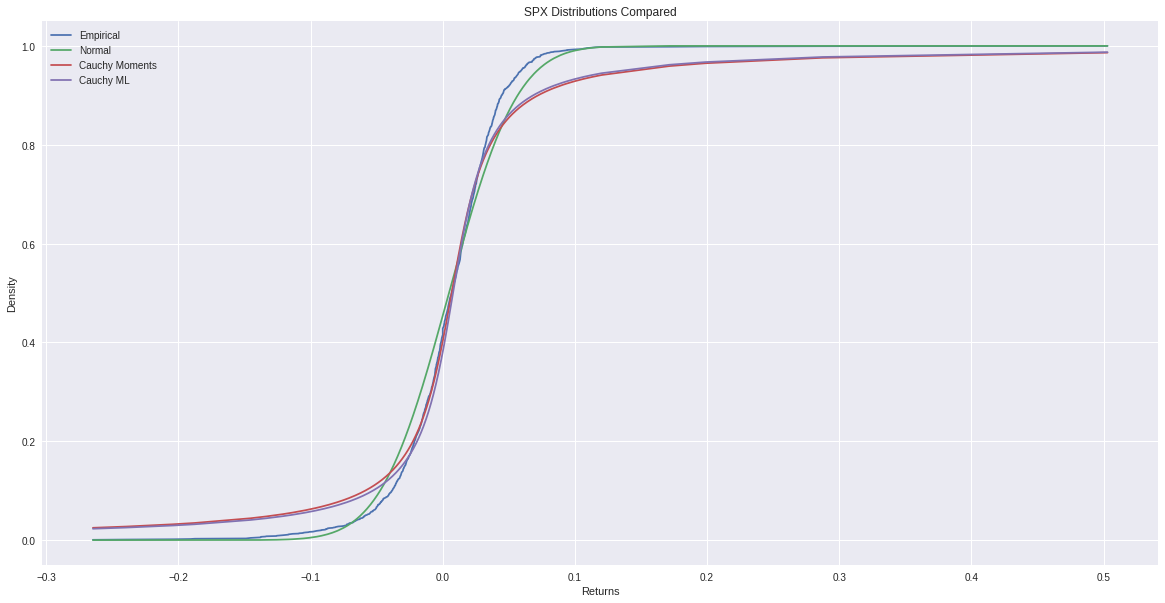

In [ ]:
# Graph the fitted distributions

plt.rcParams['figure.figsize'] = (20,10) #size of the plot
domain = spx['Ranked Returns']
plt.plot(domain, spx['Empirical CDF'], label='Empirical')
plt.plot(domain, spx['Normal CDF'], label='Normal')
plt.plot(domain, spx['Cauchy CDF (method of moments)'], label='Cauchy Moments')
plt.plot(domain, spx['Cauchy CDF (ML)'], label='Cauchy ML')
plt.title("SPX Distributions Compared")
plt.xlabel("Returns")
plt.ylabel("Density")
plt.legend()
plt.show()

As you can see, the empirical distribution demonstrates that market returns have fatter tails than the normal distribution. 

In [ ]:
# Value at Risk using percent point function (quantile function)

columns_var = ["VAR"]
var = pd.DataFrame(columns=columns_var)
var['VAR'] = [0.0025, 0.005, 0.01, 0.025, 0.05, 0.1]
var['Normal'] = norm.ppf(var['VAR'], average, stdev)
#var['Cauchy Moments'] = cauchy.ppf(var['VAR'], mu, gamma)
var['Cauchy ML'] = cauchy.ppf(var['VAR'], median_mle, iqr_mle)

display(var)

,VAR,Normal,Cauchy ML
0,0.0025,-0.109322,-2.501520
1,0.0050,-0.099936,-1.246814
2,0.0100,-0.089808,-0.619383
3,0.0250,-0.074934,-0.242677
4,0.0500,-0.062141,-0.116694
5,0.1000,-0.047392,-0.052917


With the same value at risk, there are much greater losses under the Cauchy Maximum Likelihood CDF.

In [ ]:
# Log Survival

spx_log = pd.DataFrame()

spx_log['Log Ranked Returns'] = np.log(spx['Ranked Returns'])
spx_log['Log Survival Cauchy ML'] = cauchy.logsf(spx['Ranked Returns'], median_mle, iqr_mle)
spx_log = spx_log.dropna()
display(spx_log)

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Log Ranked Returns,Log Survival Cauchy ML
Date,,
"Aug 1, 1959",-inf,-0.479507
"Jul 1, 1959",-inf,-0.479507
"Jun 1, 1959",-inf,-0.479507
"May 1, 1959",-inf,-0.479507
"Apr 1, 1959",-inf,-0.479507
...,...,...
"Jun 1, 1871",-2.118456,-2.896571
"May 1, 1871",-1.763964,-3.266093
"Apr 1, 1871",-1.615332,-3.419960


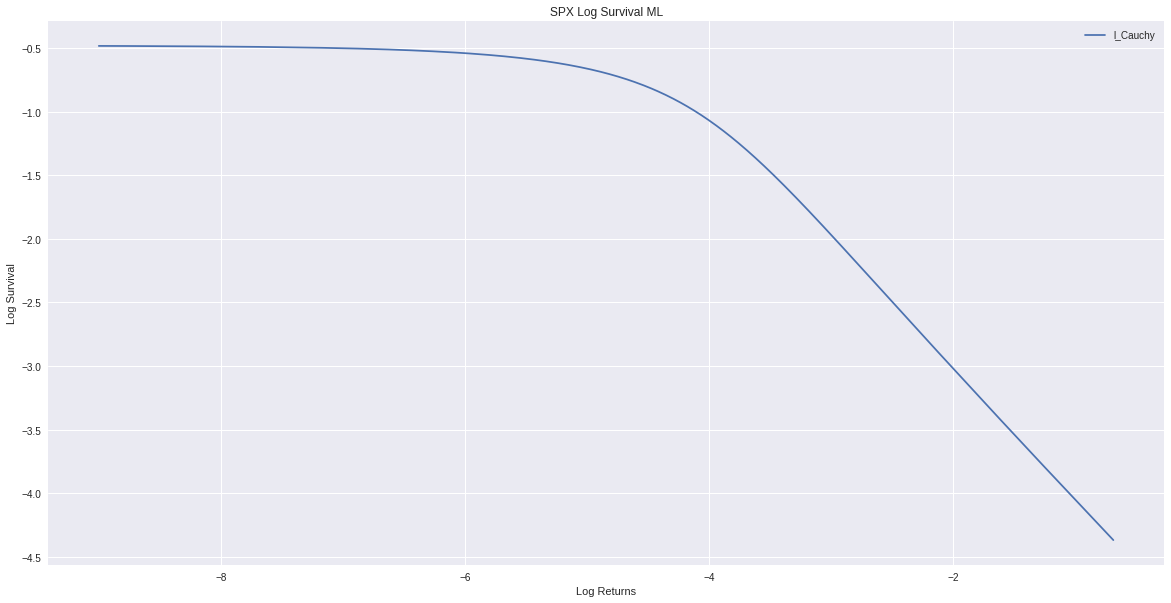

In [ ]:
# Graph Log Survival

plt.rcParams['figure.figsize'] = (20,10) #size of the plot
domain = spx_log['Log Ranked Returns']
plt.plot(domain, spx_log['Log Survival Cauchy ML'], label='l_Cauchy')
plt.title("SPX Log Survival ML")
plt.xlabel("Log Returns")
plt.ylabel("Log Survival")
plt.legend()
plt.show()

In [ ]:
# Find the limit of the Log Survival Cauchy ML as x->0

from sympy import *

x = symbols('x')
derivative_cauchy_log_survival = -(2*iqr_mle)/(3*np.pi-2*np.arctan(-median_mle/iqr_mle)*(iqr_mle**2+(-median_mle)**2))


#Limit as the derivative of log survival of cauchy approaches 0
l_cauchy = limit(derivative_cauchy_log_survival, x, 0)

print("The value of the rate of change seen on the graph above is estimated to be l")
print("l_cauchy =", l_cauchy)

The value of the rate of change seen on the graph above is estimated to be l
l_cauchy = -0.00418203364160800


# Options Pricing Heuristic

In [ ]:
# Webscrap Options Data
# Note: the Data is organized by Strike Price with the lowest strike at the top
# https://medium.com/@txlian13/webscrapping-options-data-with-python-and-yfinance-e4deb0124613


def options_chain(symbol):

  tk = yf.Ticker(symbol)
  exps = tk.options

  # Get options for each expiration
  options = pd.DataFrame()
  for e in exps:
      opt = tk.option_chain(e)
      opt = pd.DataFrame().append(opt.calls).append(opt.puts)
      opt['expirationDate'] = e
      options = options.append(opt, ignore_index=True)

  options['expirationDate'] = pd.to_datetime(options['expirationDate'])
  options['dte'] = (options['expirationDate'] - datetime.datetime.today()).dt.days / 365
    
  # Boolean column if the option is a CALL
  options['CALL'] = options['contractSymbol'].str[4:].apply(
      lambda x: "C" in x)
    
  options[['bid', 'ask', 'strike']] = options[['bid', 'ask', 'strike']].apply(pd.to_numeric)
  options['mark'] = (options['bid'] + options['ask']) / 2 # Calculate the midpoint of the bid-ask
    
  # Drop unnecessary and meaningless columns
  options = options.drop(columns = ['contractSize', 'currency', 'change', 'percentChange', 'lastTradeDate', 'lastPrice', 'impliedVolatility', 'inTheMoney', 'openInterest', 'volume', 'bid', 'ask'])



  return options

pd.set_option('max_rows', 10)
display(options_chain("^SPX"))

,contractSymbol,strike,expirationDate,dte,CALL,mark
0,SPXW220214C03600000,3600.0,2022-02-14,0.000000,True,0.0
1,SPXW220214C03800000,3800.0,2022-02-14,0.000000,True,0.0
2,SPXW220214C04000000,4000.0,2022-02-14,0.000000,True,0.0
3,SPXW220214C04050000,4050.0,2022-02-14,0.000000,True,0.0
4,SPXW220214C04060000,4060.0,2022-02-14,0.000000,True,0.0
...,...,...,...,...,...,...
12295,SPX261218P06600000,6600.0,2026-12-18,4.843836,False,0.0
12296,SPX261218P08000000,8000.0,2026-12-18,4.843836,False,0.0
12297,SPX261218P08800000,8800.0,2026-12-18,4.843836,False,0.0
12298,SPX261218P09200000,9200.0,2026-12-18,4.843836,False,0.0


In [ ]:
#Notes: https://www.youtube.com/watch?v=xvpNA7bC8cs

# Calls
spx_calls = pd.DataFrame()
spx_calls = options_chain("^SPX").loc[options_chain("^SPX").CALL==True, :]
spx_calls.reset_index(inplace=True, drop=True) #reset the index to be integers spanning the length of the dataframe
pd.to_datetime(spx_calls['expirationDate'])
print(spx_calls)

# Puts
spx_puts = pd.DataFrame()
spx_puts = options_chain("^SPX").loc[options_chain("^SPX").CALL==False, :]
spx_puts.reset_index(inplace=True, drop=True) #reset the index to be integers spanning the length of the dataframe
pd.to_datetime(spx_puts['expirationDate'])
print(spx_puts)

           contractSymbol   strike expirationDate       dte  CALL  mark
0     SPXW220214C03600000   3600.0     2022-02-14  0.000000  True   0.0
1     SPXW220214C03800000   3800.0     2022-02-14  0.000000  True   0.0
2     SPXW220214C04000000   4000.0     2022-02-14  0.000000  True   0.0
3     SPXW220214C04050000   4050.0     2022-02-14  0.000000  True   0.0
4     SPXW220214C04060000   4060.0     2022-02-14  0.000000  True   0.0
...                   ...      ...            ...       ...   ...   ...
5580   SPX261218C08400000   8400.0     2026-12-18  4.843836  True   0.0
5581   SPX261218C08600000   8600.0     2026-12-18  4.843836  True   0.0
5582   SPX261218C09000000   9000.0     2026-12-18  4.843836  True   0.0
5583   SPX261218C09200000   9200.0     2026-12-18  4.843836  True   0.0
5584   SPX261218C10000000  10000.0     2026-12-18  4.843836  True   0.0

[5585 rows x 6 columns]
           contractSymbol   strike expirationDate       dte   CALL  mark
0     SPXW220214P01200000   1200.0    

# Monte Carlo with Cauchy Maximum Likelihood

SPX last price =  4418.64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


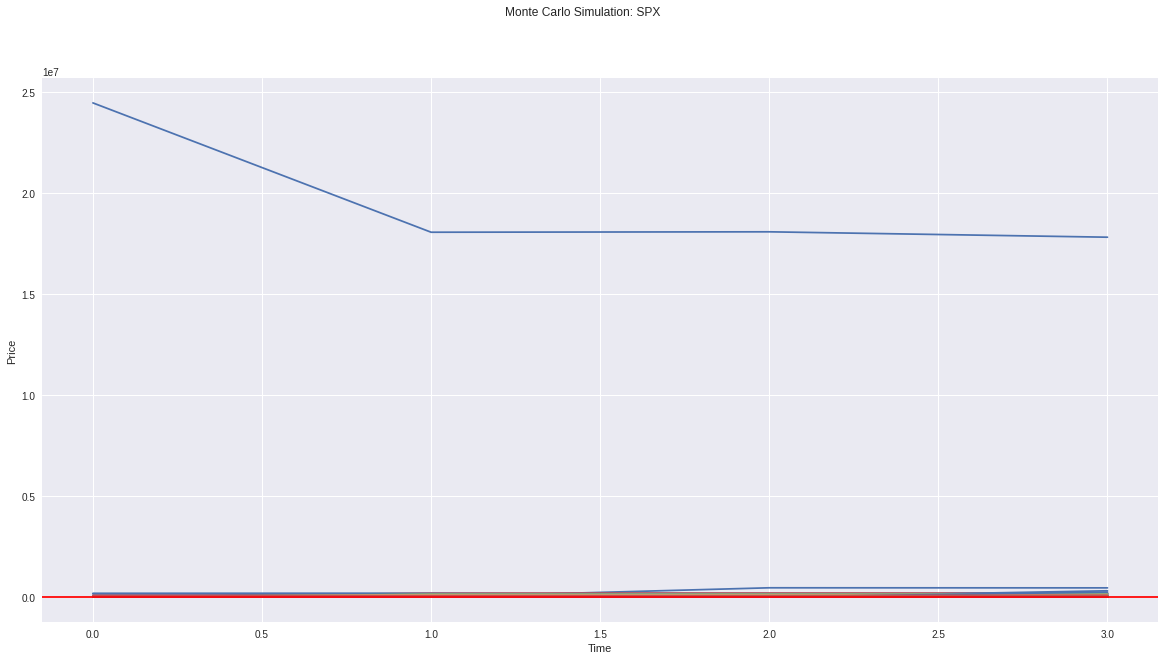

In [ ]:
#Monte Carlo

last_price = spx['Price'][0]
print("SPX last price = ", last_price)

num_simulations = 10000
num_months = 3

simulation_df = pd.DataFrame()

for x in range(num_simulations):
  count = 0

  price_series = []

  price = last_price * (1 + cauchy.ppf(random.uniform(0, 1) ,median_mle, iqr_mle))
  price = price * (price > 0)
  price_series.append(price)

  for y in range(num_months):
    if count == num_months:
      break
    
    
    price = price_series[count] * (1 + cauchy.ppf(random.uniform(0, 1) ,median_mle, iqr_mle))
    price = price * (price > 0)
    price_series.append(price)
    count += 1

  simulation_df[x] = price_series

fig = plt.figure()
fig.suptitle('Monte Carlo Simulation: SPX')
plt.plot(simulation_df)
plt.axhline(y = last_price, color = 'r', linestyle = '-')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()



# Portfolio Construction

In [ ]:
# Functions for call and put prices contingent on risk-free rate and strike price


# Options Pricing using Monte Carlo Cauchy ML
# Notes: https://www.youtube.com/watch?v=LqZ3A86LjD0, https://www.youtube.com/watch?v=15q-is8P_H4



call_strikes = pd.DataFrame()
put_strikes = pd.DataFrame()
call_strikes['strikes'] = spx_calls['strike']



# Call
def call(riskless_rate, callk):
  call_simulation = ((simulation_df.tail(1)) - (callk)) * (((simulation_df.tail(1)) - callk) > 0) # - premium #fix subtracting the premium part
  call_payoff_avg = pd.DataFrame()
  call_payoff_avg['avg'] = call_simulation.median(axis=1) # average payoff at the end of the simulation
  call_simulation['index'] = call_simulation.index
  call_payoff_avg['index'] = call_simulation['index'] 
  call_payoff = call_payoff_avg['avg']

  call_payoff = call_payoff/((1+riskless_rate)**call_payoff_avg['index'])# discount the average option price to today using the risk free rate at each time (index)
  #call_payoff[k] # convert column title to the strike price for each dataframe
  call_payoff = call_payoff.to_frame() 
  call_payoff.columns = [callk]
  return call_payoff[callk].iloc[-1]
  

# Put
def put(riskless_rate, putk):
  put_simulation = ((simulation_df.tail(1)) - (putk)) * (((simulation_df.tail(1)) - putk) > 0) # - premium #fix subtracting the premium part
  put_payoff_avg = pd.DataFrame()
  put_payoff_avg['avg'] = put_simulation.median(axis=1) # average payoff at the end of the simulation
  put_simulation['index'] = put_simulation.index
  put_payoff_avg['index'] = put_simulation['index'] 
  put_payoff = put_payoff_avg['avg']

  put_payoff = put_payoff/((1+riskless_rate)**put_payoff_avg['index']) # discount the average option price to today using the risk free rate at each time (index)
  #call_payoff[k] # convert column title to the strike price for each dataframe
  put_payoff = put_payoff.to_frame() 
  put_payoff.columns = [putk]
  return put_payoff[putk].iloc[-1]




print(call(0.02, 6000))
print(put(0.02, 2500))

-0.0
1938.5667401878768


*   max (return)
*   s.t.
*   portfolio weights = pi_i
*   sum(pi_i) = 1


